In [64]:
import warnings
warnings.filterwarnings(action='ignore')

In [65]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError as SMAPE


# import wandb

In [66]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

if torch.cuda.is_available(): device = torch.device("cuda")
elif torch.backends.mps.is_available(): device = torch.device("mps")
else: device = torch.device('cpu')

In [67]:
device

device(type='cuda')

In [68]:
# wandb.init()
# wandb.run.name = 'lstm'
# wandb.run.save()

In [69]:
class GasDataset(Dataset):
    def __init__(self, df, seq_len, year=None):
        self.seq_len = seq_len

        self.df = df
        if year is not None:
            self.df = self.df.loc[self.df['year'] == year]
    
    def __len__(self):
        return len(self.df) - self.seq_len - 1

    def __getitem__(self, idx):
        data = self.df.iloc[idx:idx + self.seq_len]
        date, x = data.date, torch.from_numpy(np.array(data[['supply']], dtype=np.float32))
        y = torch.from_numpy(np.array(self.df.iloc[idx + self.seq_len, -4], dtype=np.float32))

        return x, y

In [70]:
#https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch5-CNN-LSTM.html
class TensorExtractor(nn.Module):
    def forward(self, x):
        tensor, _ = x
        return tensor
class ReshapeData(nn.Module):
    def __init__(self, seq_len, is_input=True):
        super(ReshapeData, self).__init__()
        self.seq_len = seq_len
        self.is_input = is_input
    def forward(self, x):
        if self.is_input:
            return x.unsqueeze(1)
        else:
            return x.squeeze(1)

    
class Model(nn.Module):
    def __init__(self, model_name, input_size, hidden_size, num_layer):
        super(Model, self).__init__()
        model_layers = []
        model_layers.append(nn.BatchNorm1d(input_size))
        model_layers.append(nn.BatchNorm1d(input_size))
        if model_name == 'lstm':
            model_layers.append(nn.LSTM(input_size, hidden_size, num_layer))
        elif model_name == 'gru':
            model_layers.append(nn.GRU(input_size, hidden_size, num_layer))
        elif model_name == 'rnn':
            model_layers.append(nn.RNN(input_size, hidden_size, num_layer))
        model_layers.append(TensorExtractor())
        model_layers.append(nn.BatchNorm1d(hidden_size))
        model_layers.append(nn.Linear(hidden_size, 1))
        self.model = nn.Sequential(*model_layers)
    
    def forward(self, x):
        return self.model(x)

In [71]:
seq_len = 30
train_rate = 0.8
df = pd.read_csv("data/korea/kor_gas_day.csv")
df = df.loc[df['type'] == 'A']
train_len = int(len(df) * train_rate)

df_train, df_val = df.iloc[:train_len], df.iloc[train_len:]
train_dataset = GasDataset(df_train, seq_len)

model_name = 'lstm'
hidden_szie = 128
num_layers = 1
conv_size = 4

batch_szie = 256

# gru: 100-2 -> 127981
# lstm: 80-2 -> 117201
# rnn: 180-2 -> 120541
# transformer: 32-512-2 -> 113025
model_fig = [('gru', 100, 2),
             ('lstm', 80, 2),
             ('rnn', 180, 2)]
model_name, hidden_szie, num_layers = model_fig[0]
model = Model(model_name, seq_len, hidden_szie, num_layers).to(device)
 
train_loader = DataLoader(train_dataset, batch_size=batch_szie, shuffle=True)

model.eval()
for batch_idx, (x, y) in enumerate(train_loader):
    x = x.squeeze(-1).to(device)
    y = y.unsqueeze(-1).to(device)
    print(x.shape, y.shape)
    output = model(x)

torch.Size([256, 30]) torch.Size([256, 1])
torch.Size([256, 30]) torch.Size([256, 1])
torch.Size([256, 30]) torch.Size([256, 1])
torch.Size([256, 30]) torch.Size([256, 1])
torch.Size([256, 30]) torch.Size([256, 1])
torch.Size([256, 30]) torch.Size([256, 1])
torch.Size([185, 30]) torch.Size([185, 1])



MSE: 0.08155123144388199, MAE: 0.25934115052223206

MSE: 0.09817802906036377, MAE: 0.284858763217926

MSE: 0.038798101246356964, MAE: 0.15313754975795746

MSE: 0.08937197178602219, MAE: 0.2685260474681854

MSE: 0.0952266976237297, MAE: 0.281668484210968

MSE: 0.05615919455885887, MAE: 0.21196548640727997

MSE: 0.10976964980363846, MAE: 0.3074176013469696

MSE: 0.03695076331496239, MAE: 0.16389282047748566


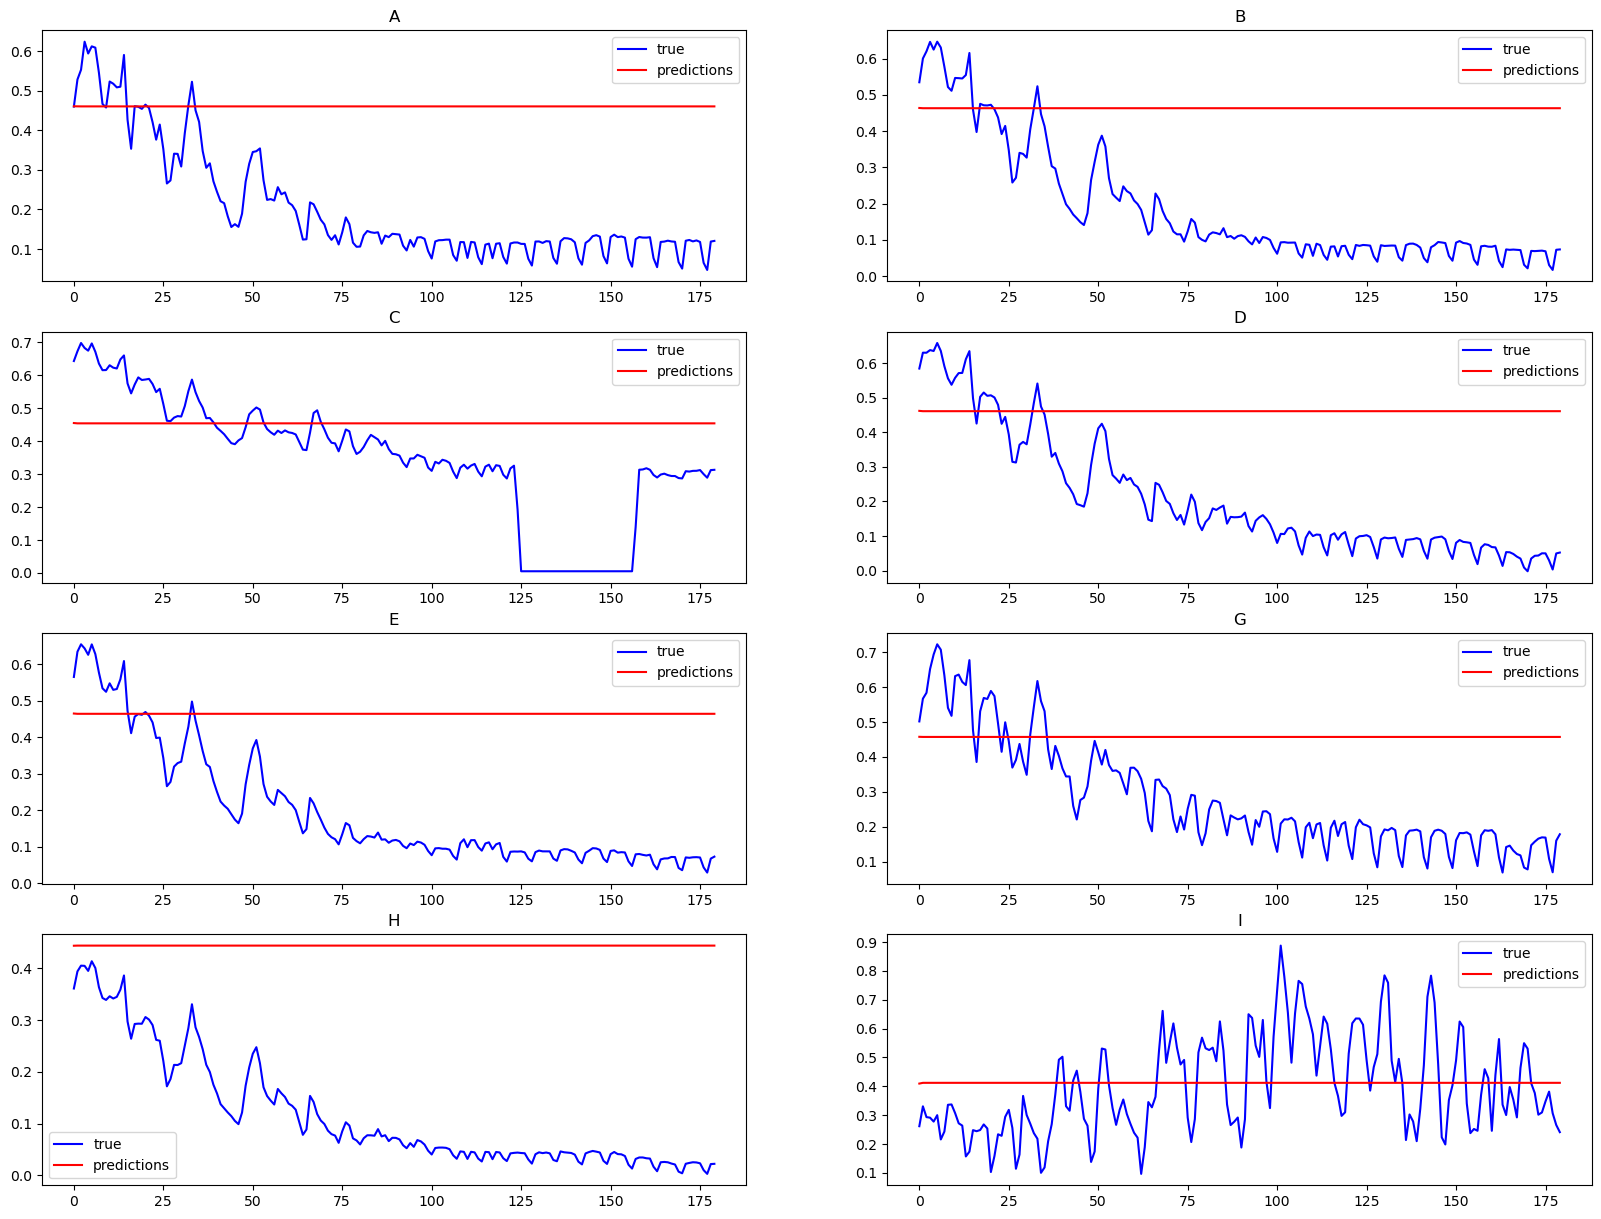

In [87]:
# from pmdarima.utils import diff, diff_inv

def train(model, train_loader_list, optimizer, criterion, epoch):
    model.train()
    for i in tqdm(range(epoch)):
        for _, train_loader, _ in train_loader_list:
            for batch_idx, (x, y) in enumerate(train_loader):
                x = x.squeeze(-1).to(device)
                y = y.unsqueeze(-1).to(device)
                
                optimizer.zero_grad()
                output = model(x)
                
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()
                # wandb.log({
                #     "epoch": i,
                #     "Loss": loss,
                #     'x': x,
                #     'y': y
                # })
        if i % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i, epoch,
                100. * i / epoch, loss.item()))

def predict_plot(model, val_data_list):
    
    model.eval()
    total_mse, total_mae = 0, 0
    sub_num = 421
    plt.figure(figsize=(20, 15))
    true_val_list, predictions_list = [], []
    for t, val_data, scaler in val_data_list:
        x = val_data[0][0].view(1, -1).to(device)
        true_val = []
        predictions = []

        mse = nn.MSELoss()
        mae = nn.L1Loss()

        with torch.no_grad():
            for i, (_, true_y) in enumerate(val_data):
                output = model(x).squeeze(-1)
                tmp = x[0][:-1].unsqueeze(0)
                x = torch.cat([tmp, output[:1].unsqueeze(0)], dim=1)

                true_val.append(float(true_y.item()))
                predictions.append(float(output.item()))
        
        total_mse += mse(torch.FloatTensor(predictions), torch.FloatTensor(true_val))
        total_mae += mae(torch.FloatTensor(predictions), torch.FloatTensor(true_val))

        x = np.arange(len(true_val))

        plt.subplot(sub_num)
        plt.rc('font', size=10)
        plt.plot(x[:180], true_val[:180], label='true', c='blue')
        plt.plot(x[:180], predictions[:180], label='predictions', c='red')
        plt.title(t)
        plt.legend()
        
        true_val_list.append((torch.FloatTensor(true_val), scaler))
        predictions_list.append((torch.FloatTensor(predictions), scaler))
        sub_num += 1
    print(f'\nMSE: {total_mse/len(val_data_list)}, MAE: {total_mae/len(val_data_list)}')
    plt.savefig(f'./paper_graph/{model_name}.png')
    plt.show()

    return true_val_list, predictions_list

true_val_list, predictions_list = predict_plot(model, val_ds_list)

In [88]:
(0.08155123144388199 + 0.09817802906036377 + 0.038798101246356964 + 0.08937197178602219 + 0.0952266976237297 + 0.05615919455885887 + 0.10976964980363846 + 0.03695076331496239) / 8

0.07575070485472679

In [73]:
seq_len = 120
train_rate = 0.8
batch_szie = 64

df = pd.read_csv("data/korea/kor_gas_day.csv")

train_dl_list = []
val_ds_list = []

for t in df['type'].unique():
    tmp = df.loc[df['type'] == t]

    df_train, df_val = tmp.iloc[:train_len], tmp.iloc[train_len:]
    scaler = MinMaxScaler() 
    npy_train = scaler.fit_transform(np.array(df_train['supply']).reshape(-1, 1))
    npy_val = scaler.transform(np.array(df_val['supply']).reshape(-1, 1))
    
    df_train.supply = npy_train
    df_val.supply = npy_val

    train_dataset = GasDataset(df_train, seq_len)
    val_dataset = GasDataset(df_val, seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_szie, shuffle=False)
    
    train_dl_list.append((t, train_loader, scaler))
    val_ds_list.append((t, val_dataset, scaler))

In [77]:
model_name = 'lstm'
hidden_szie = 256
num_layers = 3
learning_rate = 1e-3
conv = False

epochs = 100

model = Model(model_name, seq_len, hidden_szie, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss().to(device)
smape = SMAPE()


MSE: 0.08155123144388199, MAE: 0.25934115052223206

MSE: 0.09817802906036377, MAE: 0.284858763217926

MSE: 0.038798101246356964, MAE: 0.15313754975795746

MSE: 0.08937197178602219, MAE: 0.2685260474681854

MSE: 0.0952266976237297, MAE: 0.281668484210968

MSE: 0.05615919455885887, MAE: 0.21196548640727997

MSE: 0.10976964980363846, MAE: 0.3074176013469696

MSE: 0.03695076331496239, MAE: 0.16389282047748566


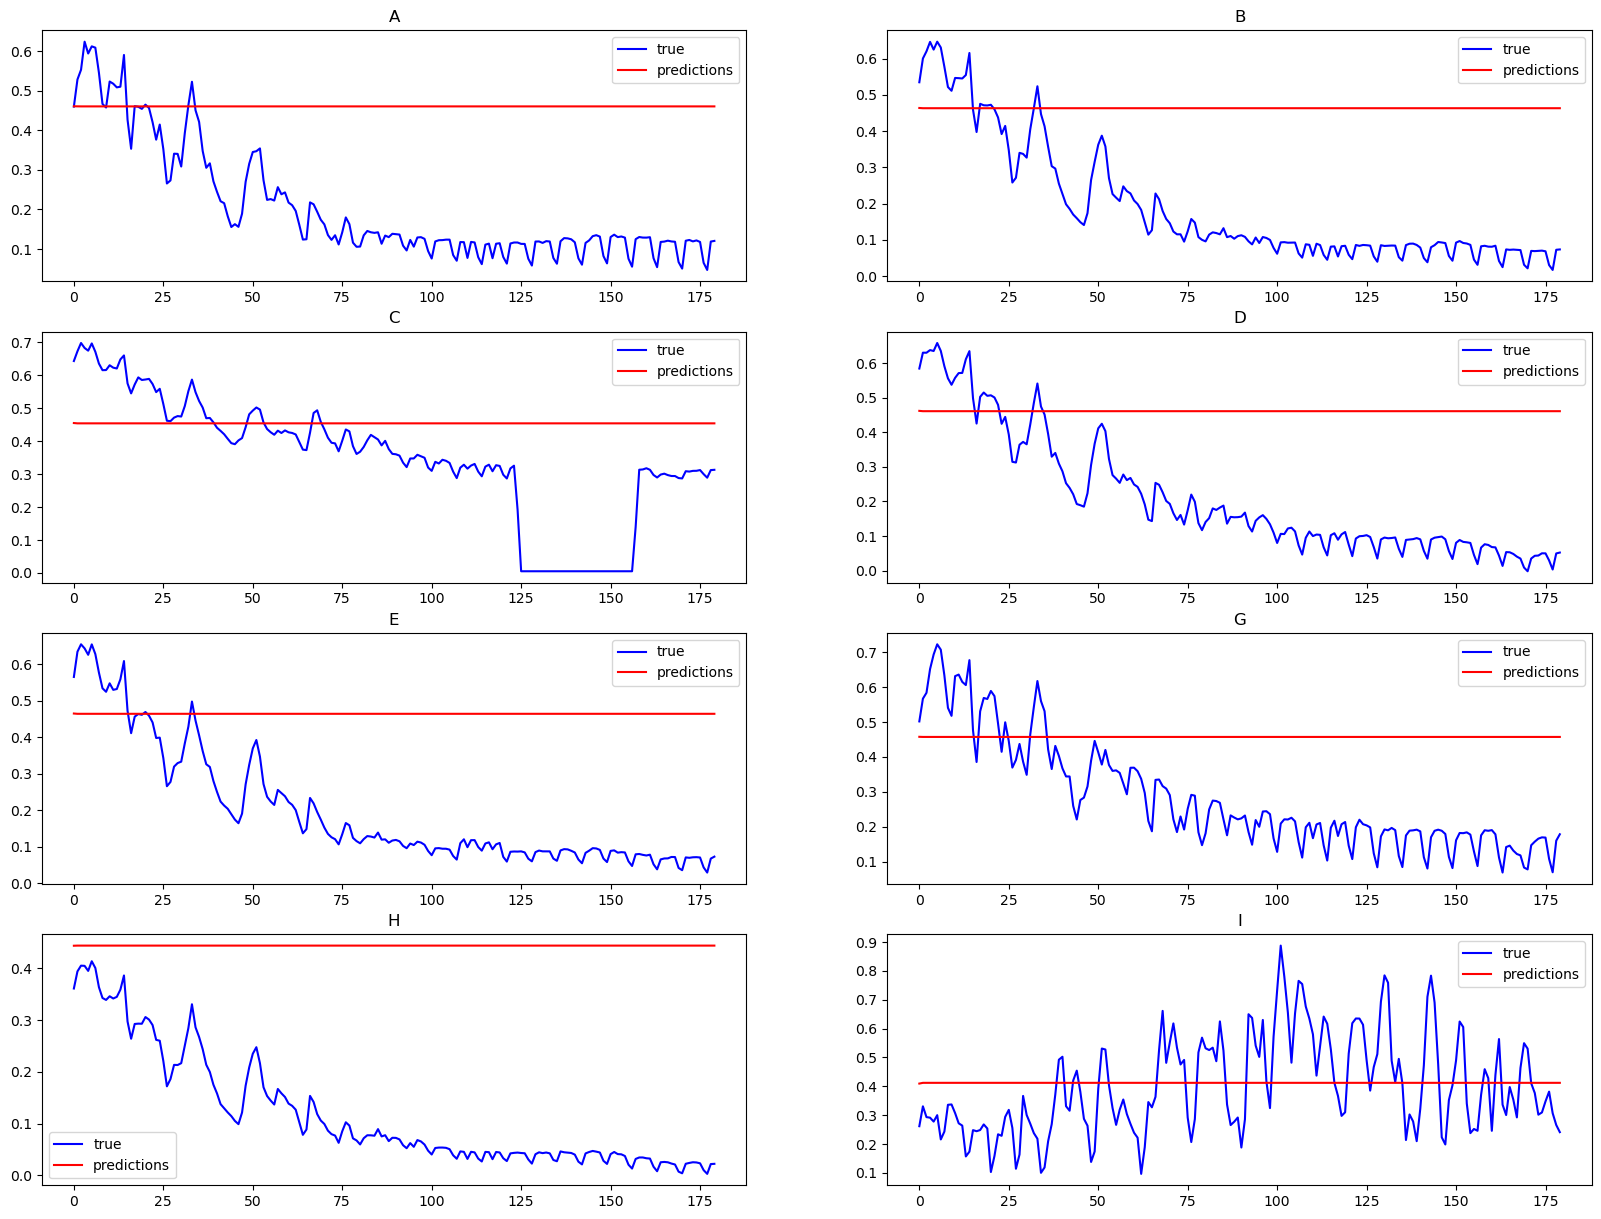

In [83]:
# results = train(model, train_dl_list, optimizer, criterion, epochs)
true_val_list, predictions_list = predict_plot(model, val_ds_list)

In [28]:
from transformer_type.model import TransAm
transformer = TransAm(feature_size=32, num_layers=2, d_ff=512)
sum(p.numel() for p in transformer.parameters() if p.requires_grad)

113025